This is essentially just a bunch of function definitions to make life a little easier

In [1]:
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import numba as nb
from numba import jit
import os
from sklearn.cluster import KMeans
import pickle
import pyfftw
from sklearn.cluster import MiniBatchKMeans
import psutil
process = psutil.Process(os.getpid())

In [2]:
def readData(fileName):
    dt = np.dtype([('header', '33c'), ('wf', '3500h')])
    s = os.stat(fileName)
    N = int((s.st_size - 8)/7033)
    with open(fileName, 'rb') as file:
        theader = np.core.records.fromfile(file,formats='Q',shape=1,byteorder='<')[0][0]
        file.seek(8)
        data = np.core.records.fromfile(file, dtype=dt ,shape=N,byteorder='<')
    return data

In [3]:
def bitLogic(data):
    # make bitlogic function and compile it to c code
    @jit(nopython=True)
    def bitLogic(x):
        for i in range(3500):
            x[i] &= 16383
            if x[i]>8191:
                x[i] -= 16384
    bitLogic(np.arange(3500, dtype='h'))
    # run over the data
    for j in range(len(data)):
        bitLogic(data['wf'][j])

In [4]:
def getPixelInfo(data):
    dh = np.dtype([
        ('result',np.ubyte), ('event id', 'i'), 
        ('board number', 'i4'), ('channel number', 'i4'),
        ('req. timestamp',np.uint64), ('cur timestamp',np.uint64),
        ('length', 'i4')])

    buf = data['header'].copy(order='C')

    headerInfo = buf.view(dh)

    headerInfo

    # lookup table as described in image
    pixel_to_bc = { '39W':(0,1),'62W':(1,1),'77W':(2,1),'39E':(3,1),'62E':(4,1),'77E':(5,1), \
                    '40W':(0,2),'63W':(1,2),'78W':(2,2),'40E':(3,2),'63E':(4,2),'78E':(5,2), \
                    '41W':(0,3),'64W':(1,3),'87W':(2,3),'41E':(3,3),'64E':(4,3),'87E':(5,3), \
                    '50W':(0,4),'65W':(1,4),'88W':(2,4),'50E':(3,4),'65E':(4,4),'88E':(5,4), \
                    '51W':(0,5),'66W':(1,5),'89W':(2,5),'51E':(3,5),'66E':(4,5),'89E':(5,5), \
                    '52W':(0,6),'75W':(1,6),            '52E':(3,6),'75E':(4,6),       \
                    '53W':(0,7),'76W':(1,7),            '53E':(3,7),'76E':(4,7) }

    bc_to_pixel = {}
    for x in pixel_to_bc.items():
        bc_to_pixel[x[1]] = x[0]

    pixel_to_bc['51W']

    bc_to_pixel[(0,5)]

    pixelIDs = []

    for i in range(len(headerInfo)):
        x = (headerInfo[i]['board number'][0], headerInfo[i]['channel number'][0])
        if x in bc_to_pixel:
            pixelIDs.append(bc_to_pixel[x])
        else:
            pixelIDs.append('NA_')
    return pixelIDs

In [5]:
# fall_times[board][channel] 
fall_times=[[1000, 1031.3367, 1086.8575, 1217.0291, 1041.5563, 1000,      1230.2096, 1188.8999],\
            [1000, 1263.1642, 1233.1743, 999.1461,  1199.1291, 1112.0769, 1049.4534, 1219.0482],\
            [1000, 1000,      1077.4932, 1157.1627, 1000,      1163.2235, 1000,      1000],\
            [1000, 1027.103,  1111.1212, 1033.5468, 1109.469,  1022.693,  1929.7336, 1000],\
            [1000, 1124.478,  1073.1306, 1007.7979, 1100.4457, 1045.0566, 1135.8975, 1073.1854],\
            [1000, 1000,      1087.187,  1133.1069, 1005.3494, 1000,      1000,      1000]]

# lookup table as described in image
pixel_to_bc = { '39W':(0,1),'62W':(1,1),'77W':(2,1),'39E':(3,1),'62E':(4,1),'77E':(5,1), \
                '40W':(0,2),'63W':(1,2),'78W':(2,2),'40E':(3,2),'63E':(4,2),'78E':(5,2), \
                '41W':(0,3),'64W':(1,3),'87W':(2,3),'41E':(3,3),'64E':(4,3),'87E':(5,3), \
                '50W':(0,4),'65W':(1,4),'88W':(2,4),'50E':(3,4),'65E':(4,4),'88E':(5,4), \
                '51W':(0,5),'66W':(1,5),'89W':(2,5),'51E':(3,5),'66E':(4,5),'89E':(5,5), \
                '52W':(0,6),'75W':(1,6),            '52E':(3,6),'75E':(4,6),       \
                '53W':(0,7),'76W':(1,7),            '53E':(3,7),'76E':(4,7) }

# put it all together to look up fall time
def fallTimeLookup(pixel):
    if (pixel not in pixel_to_bc):
        print('Could not find pixel '+pixel+' in lookup table')
        return None
    board, channel = pixel_to_bc[pixel]
    return fall_times[board][channel]

In [6]:
def amplitudes(data):
    ## Get trapezoid filter
    tau = np.int(1000)
    rise = np.int(200)
    top = np.int(100)
    trap = np.empty(3500)
    for i in range(rise):
        trap[i] = tau + i
        trap[i+rise+top] = rise - tau - i
    for i in range(rise, rise+top):
        trap[i] = rise
    for i in range(rise+top, 3500):
        trap[i] = 0
    trap = trap/(rise*tau)
    trap[rise+top:2*rise+top] = -trap[:rise]
    trapNew = np.fft.rfft(trap)

    # Get amplitudes
    f = pyfftw.interfaces.numpy_fft.irfft(pyfftw.interfaces.numpy_fft.rfft(data)*trapNew)
    E = np.amax(f, 1, keepdims=True)
    E -= np.mean(f[:,:100], 1, keepdims=True)
    return E

In [7]:
@jit(nopython=True)
def normBatch(x):
    for i in range(len(x)):
        x[i] = x[i] - np.amin(x[i])
        x[i] = x[i]*2./np.amax(x[i])
        x[i] = x[i] - 1
    return x

In [14]:
def LoadData(fileName):
    """
    Read in a calcium 45 file and predicts with k means clustering
    Returns: X(normalized), E(approx), pixelIDs, predicted Label(with 'kmean_ic')
    """
    data = readData(fileName)
    bitLogic(data)
    pixelIDs = getPixelInfo(data)
    
    E = [amplitudes(data['wf'][i*10**5 : (i+1)*10**5].astype(np.float32)) for i in range(4)]
    E = np.array(E).flatten()
    E = np.append(E, amplitudes(data['wf'][4*10**5:].astype(np.float32)))

    X = data['wf'].astype(np.float32)
    X[:10] = normBatch(X[:10])
    X = normBatch(X)

    with open('kmean_ic', 'rb') as file:
        kmean = pickle.load(file)

    pred = kmean.predict(X)
    return X, E, pixelIDs, pred

In [9]:
X, E, pixelIDs, pred = LoadData('Run_00120_00.bin')

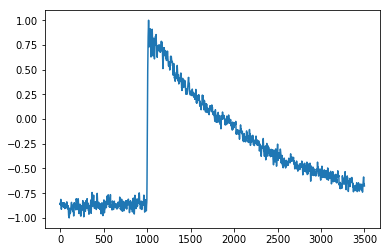

In [10]:
plot(X[-2000])

In [11]:
E[-2000]

1090.9849070894143

In [12]:
pixelIDs[-2000]

'64W'

In [13]:
pred[-2000]

9